In [7]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [8]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [49]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import networkx as nx
import scipy as si
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import tree, linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
sns.set_style("whitegrid")
sns.set_context("poster")

# Engineering Science 201: Decision Theory Final Project: Predicting Gentrification With Spatial Modeling
### May 7, 2018
### Michael Giles and Emma He
## Introduction

In recent history, gentrification has grown into an increasingly charged phenomenon, as wealthier individuals and developers capitalize on the culture of low-income neighborhoods and as a result displace the lifelong residents of those neighborhoods. The issue is particularly charged in New York City, where many feel enraged that the people who create the culture of the city can no longer afford to live there. Gentrification is complex and multifaceted, reaching into all aspects of a culture including racial, economic, and historical factors. Therefore, any attempt to measure or predict it will necessarily be reductive and lossy. However, understanding some of the most important factors in the gentrification of neighborhoods and how to point out neighborhoods at risk can help to inform stakeholders and policymakers in time to prepare appropriate responses. Gentrification likely cannot be stopped completely, but predictive tools can help us confront it more intelligently and ameliorate the strife it inflicts on cities.

## Definitions
* **PUMA** stands for Public-Use Microdata Area, a region used by the federal government to tabulate data for the American Community Survey. There are 55 PUMAs in New York city.

* **SBA** stands for Sub-Borough Area, a "neighborhood" in New York. Used interchangeably with PUMA.

* **Community District (CD)** The City of New York organizes data on the basis of the 59 community districts. For the most part, the boundaries of the CDs and the PUMAs coincide, but the United States government merged four pairs of CDs to create four PUMAs. This created aggregation issues, which we discuss more in Data Sources.

* New York City's [Furman Center](http://furmancenter.org/thestoop/entry/new-report-analyzes-new-york-citys-gentrifying-neighborhoods-and-finds-dram) defines **gentrifying neighborhods** as "consist\[ing\] of sub-borough areas (SBAs) that meet two criteria: (1) low-income \[(Defined as bottom 40th percentile in terms of mean income)\] in 1990, and (2) experienced rent growth above the median SBA rent growth between 1990 and 2014". Our predictions of neighborhoods at risk of gentrifying are neighborhoods whose median income is in the bottom 40th percentile and whose median rents are projected to grow faster than the median rent of New York City.

## Data Sources

We used data provided by New York City's [Furman Center](http://coredata.nyc/). The data consisted of yearly measurements of 7 variables of interest from 2005-2016:
* Median Rent
* Median Income
* Educational Attainment
* Ratio of residents who are white or primarily white
* Proportion of residential units within 0.5 miles of subway station in 2016
* Permits issued for new residential unit construction in the past year
* Violent Crimes per 1,000 people

The first 4 features were aggregated by the 55 federally-defined Public Use Microdata Areas (PUMAs), elsewhere called Sub-Borough-Areas (SBAs) in New York City, whereas the last 3 features were aggregated by the 59 Community Districts (CDs) defined by the city itself. For the most part, the boundaries of the two coincide. However, 4 PUMAs were created by merging 4 pairs of community districts. To obtain our last two data points in terms of the first two, we merged the four pairs of Community Districts into their corresponding PUMAs via a weighted average of the relevant population of each, weighting the new unit construction by the total number of residential units in each CD and the violent crime rate by the total population of each CD, which we obtained from the 2010 census. Crime statistics for 2005 were missing -- we filled in values using data from 2006 and used linear interpolation to fill in missing values in the crime statistics and new apartment units statistics.

In [251]:
# merge puma codes with sub-bourough data
years = [str(y) for y in range(2005,2017)]
puma_cd_name = pd.read_csv('../data/PUMA_CD_NAME.csv',index_col = 0)
median_rents = pd.read_csv('../data/sub-borougharea-medianrentall2016.csv')
median_rents = median_rents.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_rents = median_rents.set_index('puma')
median_rents = median_rents.sort_index()
median_incomes = pd.read_csv('../data/sub-borougharea-medianhouseholdincome2016.csv')
median_incomes = median_incomes.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
median_incomes = median_incomes.set_index('puma')
median_incomes = median_incomes.sort_index()
education_levels = pd.read_csv('../data/sub-borougharea-populationaged25withabachelorsdegreeorhigher.csv')
education_levels = education_levels.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
education_levels = education_levels.set_index('puma')
education_levels = education_levels.sort_index()
percents_white = pd.read_csv('../data/sub-borougharea-percentwhite.csv')
percents_white = percents_white.merge(puma_cd_name, left_on = 'Sub-Borough Area', right_on = 'CD_Name', how = 'outer')
percents_white = percents_white.set_index('puma')
percents_white[years] = percents_white[years].interpolate(method='linear', axis = 0)
percents_white = percents_white.sort_index()
nyc_median_incomes = pd.read_csv('../data/city-medianhouseholdincome2016.csv')
nyc_median_rents = pd.read_csv('../data/city-medianrentall2016.csv')
subways = pd.read_csv('../data/communitydistrict-residentialunitswithin12mileofasubwaystation.csv')

In [179]:
subways['cd'], subways['CD_Name'] = subways['Community District'].str.split(" - ",1).str
subways['cd'] = subways['cd'].str.replace(" ", "")

In [180]:
# # Merge community district data into PUMAs based on 2010 census
housing_units = pd.read_csv('../data/community_district_housing_units2010.csv')
housing_units['cd'] = housing_units['Community_District'].str.lstrip()
housing_units['cd'] = housing_units['cd'].str.rstrip()
housing_units['Borough'], housing_units['CD_Number'] = housing_units['cd'].str.split(" ",1).str
housing_units['CD_Number']= housing_units['CD_Number'].str.zfill(2)
housing_units['cd'] = housing_units['Borough'] + housing_units['CD_Number']
housing_units = housing_units[['cd', 'Units']]
housing_units['Units'] = housing_units['Units'].str.replace(',','').astype('int64')

In [181]:
population = pd.read_csv('../data/community_district_population2010.csv')
population['cd'] = population['Community_District'].str.lstrip()
population['cd'] = population['cd'].str.rstrip()
population['Borough'], population['CD_Number'] = population['cd'].str.split(" ",1).str
population['CD_Number']= population['CD_Number'].str.zfill(2)
population['cd'] = population['Borough'] + population['CD_Number']
population = population[['cd', 'Population']]

In [182]:
merging = [('BX01', 'BX02'), ('BX03', 'BX06'), ('MN01', 'MN02'), ('MN04', 'MN05')]
years = [str(y) for y in range(2005,2017)]

In [183]:
subways = subways[['cd', '2016']]
merged = []
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    newval = u *subways[subways['cd']==a]['2016'].values[0] + v * subways[subways['cd']==b]['2016'].values[0]
    newval = newval / float(denom)
    merged.append({
        'cd': a + b, 
        '2016': newval})
subways = subways.append(merged, ignore_index = True)
subways = subways.merge(puma_cd_name, on = 'cd', how = 'outer')
subways = subways.dropna(how='any')
subways['puma'] = subways['puma'].astype('int')
subways = subways.set_index('puma')
subways = subways.sort_index()
subways = pd.concat([subways['2016']]*12, axis=1)
subways.columns = years

In [184]:
new_units = pd.read_csv('../data/communitydistrict-unitsauthorizedbynewresidentialbuildingpermits.csv')
new_units['cd'], new_units['Name'] = new_units['Community District'].str.split(" - ",1).str
new_units['cd'] = new_units['cd'].str.replace(' ','')
years = [str(n) for n in range(2000,2017)]
indices = ['cd', 'Name'] + years
new_units = new_units[indices]
for i,(a,b) in enumerate(merging):
    u = float(housing_units[housing_units['cd']==a]['Units'].values[0])
    v = float(housing_units[housing_units['cd']==b]['Units'].values[0])
    denom = u + v
    row1 = new_units[new_units['cd']==a][years].values
    row2 = new_units[new_units['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    new_units = new_units.append(newrow, ignore_index = True)
new_units = new_units.merge(puma_cd_name, on='cd', how='outer')
new_units = new_units[pd.notnull(new_units['CD_Name'])]
new_units['puma'] = new_units['puma'].astype('int64')
new_units = new_units.set_index('puma')
new_units[years] = new_units[years].interpolate(method='linear', axis = 0)
new_units = new_units.sort_index()

In [185]:
crime = pd.read_csv('../data/communitydistrict-seriouscrimerateper1000residents.csv')
crime['cd'], crime['CD_Name'] = crime['Community District'].str.split(" - ",1).str
crime['cd'] = crime['cd'].str.replace(' ','')
years = [str(n) for n in range(2006,2017)]
indices = ['cd'] + years
crime = crime[indices]
for i,(a,b) in enumerate(merging):
    u = float(population[population['cd']==a]['Population'].values[0])
    v = float(population[population['cd']==b]['Population'].values[0])
    denom = u + v
    row1 = crime[crime['cd']==a][years].values
    row2 = crime[crime['cd']==b][years].values
    newvals = (u * row1 + v * row2) / denom
    newrow = new_units[new_units['cd']==a].copy()
    newrow = pd.DataFrame(newvals, columns=years) 
    newrow['cd'] = a + b
    crime = crime.append(newrow, ignore_index = True)
crime = crime.merge(puma_cd_name, on='cd', how='outer')
crime = crime[pd.notnull(crime['CD_Name'])]
crime['puma'] = crime['puma'].astype('int64')
crime = crime.set_index('puma')
crime = crime.sort_index()

# horrendous and lazy way to fill in missing values
lineup = crime['2006'].values
crime.insert(0, '2005', lineup)

Here is an example of what our data looked like:

In [58]:
median_rents.head()

,short_name,long_name,Sub-Borough Area,2000,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,cd,CD_Name
puma,,,,,,,,,,,,,,,,,,
3701,gross_rent_adj,"Median rent, all ($2016)",Riverdale/Kingsbridge,1060,1090,1120,1140,1170,1200,1230,1240,1240,1290,1200,1310,1310,BX08,Riverdale/Kingsbridge
3702,gross_rent_adj,"Median rent, all ($2016)",Williamsbridge/Baychester,1000,1070,1100,1110,1120,1160,1150,1190,1200,1240,1220,1210,1250,BX12,Williamsbridge/Baychester
3703,gross_rent_adj,"Median rent, all ($2016)",Throgs Neck/Co-op City,950,990,1050,1020,1140,1070,1130,1150,1020,1110,1130,1070,1200,BX10,Throgs Neck/Co-op City
3704,gross_rent_adj,"Median rent, all ($2016)",Pelham Parkway,1000,1080,1040,1130,1080,1130,1140,1180,1200,1160,1240,1260,1270,BX11,Pelham Parkway
3705,gross_rent_adj,"Median rent, all ($2016)",Morrisania/Belmont,690,810,850,870,870,910,900,930,900,940,910,960,970,BX03BX06,Morrisania/Belmont


## Testing Our Features

To test the relevance of our features and to get an idea of their effect on the independent variable, we performed principal component analysis on each of the neighborhoods:

In [59]:
n = 12 # number of years
m = 6 # number of features
k = 55 # number of PUMAs
years = [str(y) for y in range(2005,2017)]

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, subways[years].values, new_units[years].values, crime[years].values]
feature_labels = ['median_incomes', 'education_level', 'percent_white', 'subways', 'new_units', 'crime']

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

X = np.dstack(features)    
    
Y = median_rents[years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))

X_test = X[:,-2:,:]
Y_test = Y[:,-2:]
Y_train = Y[:,:-2]
X_train = X[:, :-2, :]

Principal component analysis (PCA) is a linear transformation of the data into an uncorrelated orthogonal basis composed of the principal components. Principal components are the orthogonal axes that account for the most variability within the data. The principal components are ordered by the amount of variability they capture, with the first principal component having the most variance. They are calculated by finding the eigenvalues of $\mathbf{X}^T\mathbf{X}$:
$$T = \mathbf{WX}$$
Where $\mathbf{W}$ is the matrix whose columns are the eigenvectors of $\mathbf{X^TX}$, sorted by decreasing eigenvalue.
We used PCA to identify the most important features of each neighborhood to predict rent. Since our variables were measured on very different scales (0.3 vs 3000), it was important that we standardized our data by mean-subtracting and scaling to unit norm. 

In [60]:
pcas = np.zeros((k,m,m))
expratios = np.zeros((k,m))
pca = PCA()
for i in range(k):
    pca = pca.fit(X_train[i], Y_train[i])
    pcas[i] = pca.components_
    expratios[i] = pca.explained_variance_ratio_

The first three components explain about 90 percent of the variation in median rents for most neighborhoods, but it varies:

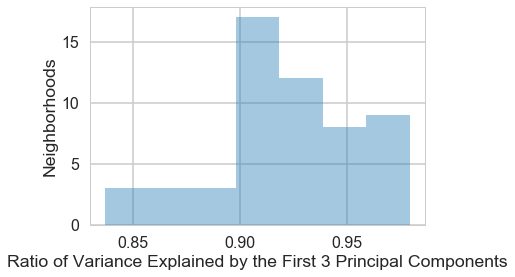

In [61]:
sns.distplot(expratios[:,:3].sum(axis=1), kde=False)
plt.xlabel('Ratio of Variance Explained by the First 3 Principal Components')
plt.ylabel('Neighborhoods')
plt.show()

We can look at the ways our features correlate with one another

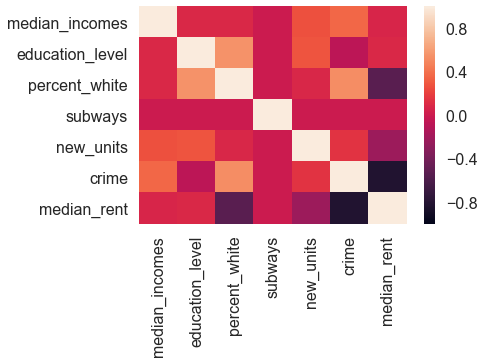

In [62]:
Cs = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
for i in range(1,k):
    m = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
    Cs=np.dstack([Cs,m])
sns.heatmap(Cs.mean(axis=2), xticklabels = feature_labels+['median_rent'], yticklabels = feature_labels + ['median_rent'], vmin = -1, vmax =1)
plt.show()

From this, it appears that our subways data is not heopful. We can get an idea of the importance of each of the features by summing up the weights given to each feature for each neighborhood in the first two PCs:

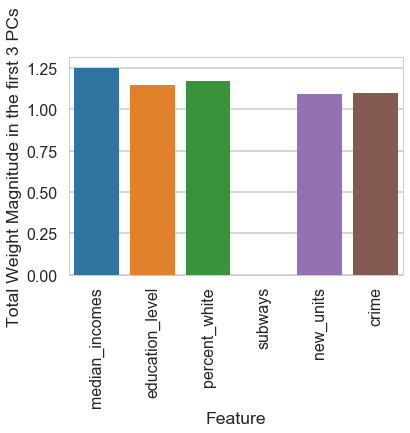

In [63]:
ax = sns.barplot(x = feature_labels, y = abs(pcas)[:,:3].sum(axis=1).mean(axis=0))
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Total Weight Magnitude in the first 3 PCs')
plt.show()

So we conclude that our proportion of subways data is irrelevant and discard it

## Lagging
### Temporal
For time series data, a common practice is to _lag_ the data with itself by comparing current values of the data with past values, as the current value depends on the past value. The way we will do this first is by computing the _Exponential Moving Average_ ($S_t$) for all of the median rents, where $S_t$ is defined recursively as
$$ S_t = \begin{cases} 
Y_1 & t = 0 \\ 
\frac{1}{1 + c} Y_t + \frac{c}{1+c} S_{t-1} & t > 0 
\end{cases} $$
$c$ being the center of mass of the moving average, which we chose as $2$, and adding it as a feature:

In [64]:
years = [str(y) for y in range(2005,2016)]
ema = median_rents[years].ewm(com=2).mean().values

Additionally, we will lag the our observations forward 1 year, so that we can predict next year's rent from this year's data

In [217]:
n = 11 # number of years
m = 6 # number of features
k = 55 # number of PUMAs

years = [str(y) for y in range(2005,2016)]
# Lagged forward 1
obs_years = [str(y) for y in range(2006,2017)]

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, new_units[years].values, crime[years].values, ema]
feature_labels = ['median_incomes','education_level', 'percent_white', 'new_units', 'crime', 'ema']

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

X = np.dstack(features)    
    
Y = median_rents[obs_years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))

X_test = X[:,-2:,:]
Y_test = Y[:,-2:]
Y_train = Y[:,:-2]
X_train = X[:, :-2, :]

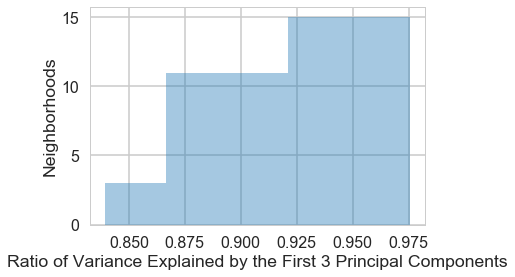

In [66]:
pcas = np.zeros((k,m,m))
expratios = np.zeros((k,m))
pca = PCA()
for i in range(k):
    pca = pca.fit(X_train[i], Y_train[i])
    pcas[i] = pca.components_
    expratios[i] = pca.explained_variance_ratio_
sns.distplot(expratios[:,:3].sum(axis=1), kde=False)
plt.xlabel('Ratio of Variance Explained by the First 3 Principal Components')
plt.ylabel('Neighborhoods')
plt.show()

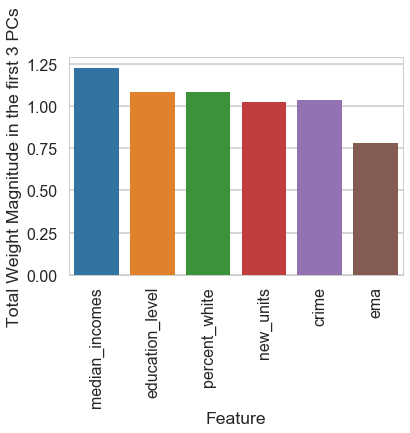

In [67]:
ax = sns.barplot(x = feature_labels, y = abs(pcas)[:,:3].sum(axis=1).mean(axis=0))
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Total Weight Magnitude in the first 3 PCs')
plt.show()

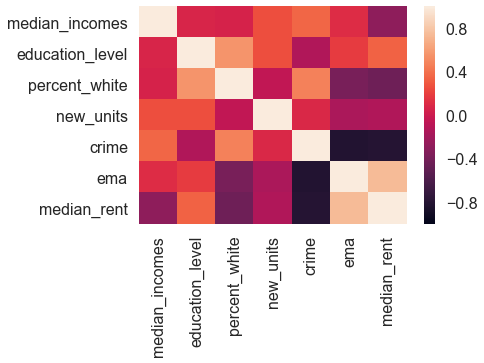

In [68]:
Cs = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
for i in range(1,k):
    m = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
    Cs=np.dstack([Cs,m])
sns.heatmap(Cs.mean(axis=2), xticklabels = feature_labels+['median_rent'], yticklabels = feature_labels + ['median_rent'], vmin = -1, vmax =1)
plt.show()

## Spatial
We believed that the spatial component of rent prices is is important as well, and wanted to include it as a feature. To do so, we used the _spatial lag_ $W Y_i$, where $W$ is a weight matrix relating the neighborhoods to each other in space. In the simplest case, $W$ is a stochastic matrix (all the rows add up to 1) of first-degree neighbors, and $W Y_i$ is the mean rent of all of the neighborhoods surrounding neighborhood $i$. To get this information, we found a map file for all of the PUMAs in New York City

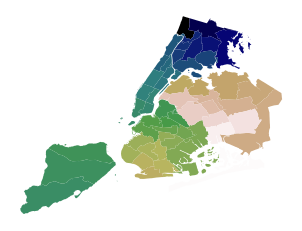

In [69]:
sns.set_style("white")
sbas = gpd.read_file('../data/Public Use Microdata Areas (PUMA)/')
sbas['puma'] = sbas['puma'].astype('int64')
sbas = sbas.merge(puma_cd_name, on='puma')
sbas['cd'] = sbas['cd'].str.replace(" ","")
ax = sbas.plot(cmap='gist_earth')
sns.despine(top=True, left=True, right= True, bottom=True)
ax.set(xticklabels=[],yticklabels=[])
plt.show()

And generated a network connecting first-degree neighbors

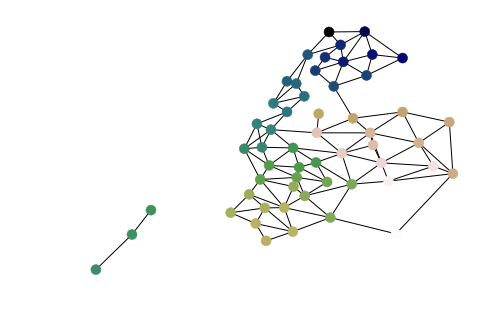

In [70]:
G = nx.Graph()
G.add_nodes_from(sbas.index)
n = len(sbas.index)
for i,row in sbas.iterrows():
    for j in range(i+1,n):
        if row['geometry'].touches(sbas.loc[j]['geometry']):
            dist = row['geometry'].centroid.distance(sbas.loc[j]['geometry'].centroid) 
            G.add_edge(i,j, weight=dist)
nx.draw(G, pos = sbas['geometry'].centroid.map(lambda p: (p.x,p.y)).to_dict(), node_size=100, node_color=range(n), cmap=plt.cm.gist_earth)
plt.show()

$W$ is then

In [71]:
W = np.ceil(nx.to_numpy_matrix(G))
for i, row in enumerate(W):
    W[i] = row / row.sum()
W

matrix([[ 0.        ,  0.33333333,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.2       ,  0.        ,  0.2       , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.33333333,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ..., 
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.25      ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.25      ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [72]:
columns = ['cd'] + years
spatial_lag1 = pd.DataFrame()
for v in G.nodes():
    puma = sbas.iloc[v]['puma']
    neighbors = G[v].keys()
    neighbor_cds = list(sbas.iloc[neighbors]['cd'])
    rent_rows = median_rents[median_rents['cd'].isin(neighbor_cds)][columns]
    Wyi = rent_rows.mean()
    Wyi['puma'] = puma
    spatial_lag1 = spatial_lag1.append(Wyi, ignore_index=True)
spatial_lag1['puma'] = spatial_lag1['puma'].astype('int')
spatial_lag1 = spatial_lag1.set_index('puma')
spatial_lag1 = spatial_lag1.sort_index()

In [163]:
n = 11 # number of years
m = 7 # number of features
k = 55 # number of PUMAs

features = [median_incomes[years].values, education_levels[years].values, percents_white[years].values, new_units[years].values, crime[years].values, spatial_lag1, ema] 
feature_labels = ['median_incomes', 'education_level', 'percent_white', 'new_units', 'crime', 'spatial_lag','ema']

# Normalize features
for i in range(len(features)):
    features[i] = features[i] - np.repeat(np.mean(features[i], axis = 1).reshape(k,1), n, axis = 1)
    features[i] = normalize(features[i])

X = np.dstack(features)    
    
Y = median_rents[obs_years].astype('float32').values
Y = Y - np.repeat(np.mean(Y, axis = 1).reshape(k,1), n, axis = 1)
Y = np.divide(Y, np.linalg.norm(Y, axis = 1).reshape(k,1))

X_test = X[:,-2:,:]
Y_test = Y[:,-2:]
Y_train = Y[:,:-2]
X_train = X[:, :-2, :]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # Remove the CWD from sys.path while we load stuff.


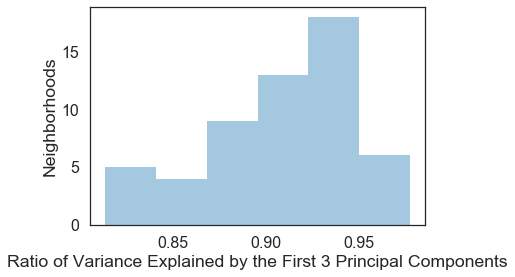

In [74]:
pcas = np.zeros((k,m,m))
expratios = np.zeros((k,m))
pca = PCA()
for i in range(k):
    pca = pca.fit(X_train[i], Y_train[i])
    pcas[i] = pca.components_
    expratios[i] = pca.explained_variance_ratio_
sns.distplot(expratios[:,:3].sum(axis=1), kde=False)
plt.xlabel('Ratio of Variance Explained by the First 3 Principal Components')
plt.ylabel('Neighborhoods')
plt.show()

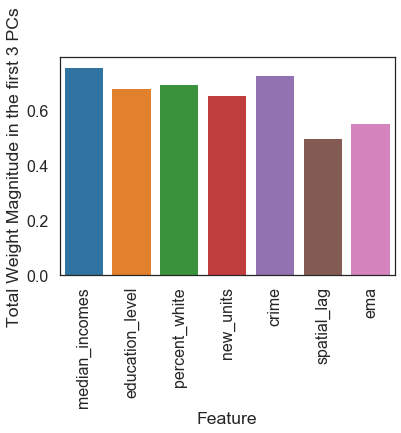

In [75]:
ax = sns.barplot(x = feature_labels, y = abs(pcas)[:,:2].sum(axis=1).mean(axis=0))
plt.xticks(rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Total Weight Magnitude in the first 3 PCs')
plt.show()

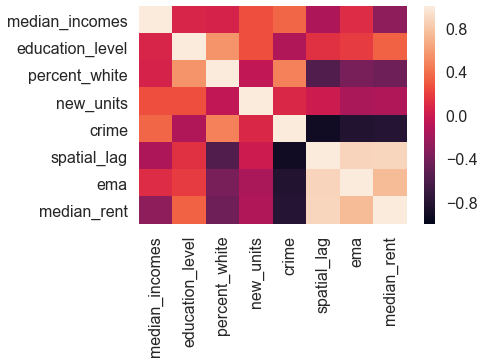

In [76]:
Cs = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
for i in range(1,k):
    m = np.corrcoef(np.append(X[0],Y[0].reshape(n,1), axis=1).T)
    Cs=np.dstack([Cs,m])
sns.heatmap(Cs.mean(axis=2), xticklabels = feature_labels+['median_rent'], yticklabels = feature_labels + ['median_rent'], vmin = -1, vmax =1)
plt.show()

So all the remaining features are likely valuable predictors for median rent prices.

# Model 1: Linear Regression

Using our features, we set up a simple linear regression problem
$$ \mathbf{Y}_i = \mathbf{X}_i \theta_i + \epsilon_i$$
Where $\epsilon_i \sim N(0,\sigma^2_iI)$ for each neighborhood $i$. We trained our linear model on the first 10 years, reserving the last two for testing.

In [77]:
clf = linear_model.LinearRegression()
predictions = np.zeros((k,2))
rvals = np.zeros(k)
mses = np.zeros(k)
residslin2 = np.zeros(k)
for i in range(k):
    clf = clf.fit(X_train[i], Y_train[i])
    predictions[i,:] = clf.predict(X_test[i,:])
    rvals[i] = clf.score(X_train[i], Y_train[i])
    mses[i] = mean_squared_error(Y[i], clf.predict(X[i]))
    residslin2[i] = Y_test[i,1] - clf.predict(X_test[i,1].reshape(1, -1))

We measured the mean-squared error of our fit for every neighborhood:

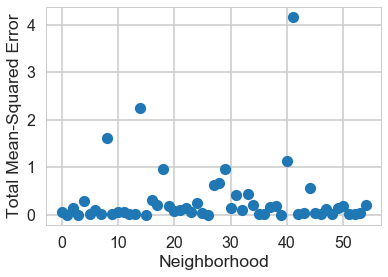

In [78]:
sns.set_style("whitegrid")
plt.plot(mses, 'o')
plt.xlabel('Neighborhood')
plt.ylabel('Total Mean-Squared Error')
plt.show()

As well as the residuals for predicting median rents in 2016

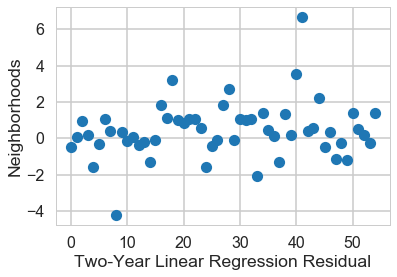

In [79]:
plt.plot(residslin2, 'o')
plt.ylabel('Neighborhoods')
plt.xlabel('Two-Year Linear Regression Residual')
plt.show()

# Model 2: Decision Tree Regression
The next model we used is a decision tree regressor. Given $\mathcal{D} = (\mathbf{X}_i, Y_i)_{i=0}^{n}, \ X_i \in \mathbb{R}^{p}$, $Y_{i} \in \mathbb{R}$ the decision tree regressor iterates through the $p$ features to find a _decision rule_ $(j,a), j \in {1, \dots, p}$ that partitions $\mathcal{D}$ into two disjoint subsets, $\mathcal{D}_{x_j \leq a} \equiv (X^Y,Y^Y)$ and $\mathcal{D}_{x_j > a} \equiv (\mathbf{X}^N, Y^N)$, where $x_j$ is the $j$\textsuperscript{th} feature defining a split of the data into two subsets, $\mathcal{D}_{x_j \leq a}(\mathbf{X}, Y) \equiv (\mathbf{X}^Y, Y^Y)$ and $\mathcal{D}_{x_j > a}(\mathbf{X}, Y)\equiv (\mathbf{X}^N, Y^N)$, where $x_j$ is one of the values of the features in $\mathbf{X}$. $(j,a)$
$$(j,a) = \text{argmin}_{\mathcal{D}_{x_k \leq b}} \sum_{y \in Y^Y} (y - \bar{Y}^Y)^2 + \sum_{y \in Y^N} (y - \bar{Y}^N)^2$$
Where $\bar{Y}^Y$ and $\bar{Y}^N$ are the means of the two subsets, respectively. This process is then repeated on $(X^Y,Y^Y)$ and $(Y^N,Y^N)$ recursively until some end condition is met. In the case of our regression, the end condition was that no more splitting could be performed. Classification is performed by following the decision rules to a leaf and returning the mean value at that leaf.

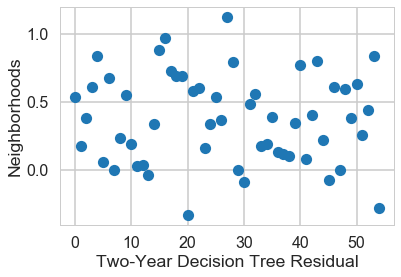

In [80]:
residstree = np.zeros(k)
for i in range(k):
    regr = tree.DecisionTreeRegressor()
    regr.fit(X_train[i], Y_train[i])
    rvals[i] = regr.score(X[i],Y[i])
    residstree[i] = Y_test[i,1] - regr.predict(X_test[i,1].reshape(1, -1))
plt.plot(residstree, 'o')
plt.ylabel('Neighborhoods')
plt.xlabel('Two-Year Decision Tree Residual')
plt.show()

In general, this model had smaller residuals than did our linear regression. However, it systematically underestimated 2016's rent for each neighborhood.

# Model 3: Random Forest Regression

Random forest regression uses $T$ decision trees in parallel. Rather than training on all the data, however, each of the trees is a trained on a subset of size $n$ drawn from the data with replacement. In addition, at each node a random subset of up to $m$ features is considered to perform the split. We used $T=10$ and $m=p$.

In [81]:
residsfrst = np.zeros(k)
for i in range(k):
    regr = RandomForestRegressor()
    regr.fit(X_train[i], Y_train[i])
    rvals[i] = regr.score(X_test[i],Y_test[i])
    residsfrst[i] = Y_test[i,1] - regr.predict(X_test[i,1].reshape(1, -1))

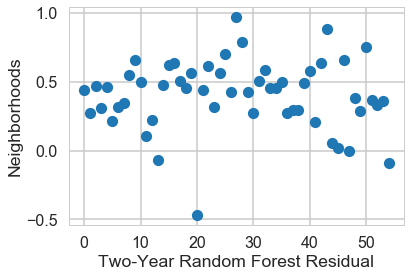

In [82]:
plt.plot(residsfrst, 'o')
plt.ylabel('Neighborhoods')
plt.xlabel('Two-Year Random Forest Residual')
plt.show()

# Model 4: LSTM

Finally, we tried to predict median rents using a [long-short term memory](http://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/) (LSTM) network. Recurrent neural networks (RNNs) are structured to handle dynamic data such as time series. We can represent an RNN with: 

$$h_t=\sigma(\mathbf{U}_t+\mathbf{V}_{t−1})$$

where $\mathbf{U}$ is the weight matrix of the inputs and $\mathbf{V}$ is the weight matrix of the recurrent outputs. However, RNNs do not generalize well to evaluations of longer time series, due to the high potential of a vanishing gradient as our number of time steps increases. LSTMs handle the vanishing gradient problem by introducing the LSTM cell, which adds an internal memory state to the processed input. LSTM cells modulate processing with 3 gates: an input gate, an output gate, and a forget gate. 

The input is first restricted to values between -1 and 1: 

$$g = \text{tanh}(b^g+x_t\mathbf{U}^g+h_{t−1}\mathbf{V}^g)$$

where $\mathbf{U}^g$ is the weight of the input, $\mathbf{V}^g$ is the weight of the previous cell output, and $b^g$ is the input bias.
The output of the input gate is $g\circ i$, where $i = \sigma(b_i+x_t\mathbf{U}^i+h_{t−1}\mathbf{V}^i)$.

The internal memory of the LSTM cell is contained in state st, which is lagged by one. This is passed through the forget gate, which determines which previous states to remember. This is all added to the input (as discussed above).
The output of the forget gate is then 

$s_t=s_{t−1}\circ f+g\circ i$, where $f=\sigma(b_f+x_t\mathbf{U}^f+h_t−1\mathbf{V}^f)$. 

The output gate of the LSTM cell then returns 

$$h_t=\text{tanh}(s_t)\circ o, \ o=\sigma(b_o+x_t\mathbf{U}^o+h_t−1\mathbf{V}^o)$$

Due to the size of the dataset, it was important to select an appropriate batch size and network size to avoid overfitting. After testing various batch sizes, network sizes, and number of epochs, we settled on the method implemented here: https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/, with some adjustments based on empirical observations. For training, our batch size was equal to the number of training observations. For testing, we created a new model using the training weights so that we could re-define the batch size to be 1. We found that loss did not decrease appreciably after 500 epochs.

LSTM was computationally expensive and took a significant amount of time to run for all 55 PUMAs. Ultimately, the model did not perform better than the much simpler random forest regressor. This is most likely because the complexity of the RNN was unnecessary given the size of our dataset.

In [ ]:
train_features = ['median_incomes', 'education_level', 'percent_white', 'new_units',
       'crime', 'spatial_lag', 'emw']
residslstm = np.zeros((55,1))

for i in range(0,55):
    focus = pd.DataFrame(X[i], columns = feature_labels)
    focus = focus.drop('subways', axis = 1)
    focus_obs = pd.DataFrame(Y[i], columns = ['median_rent'])
    focus = pd.concat([focus, focus_obs.shift(-1)], axis=1)
    focus.dropna(how='any')
    test = focus[train_features].iloc[10]
    test_X = test.values
    test_X = test_X.reshape(1,1,7)
    train = focus.iloc[:10]
    train_X = train[train_features].values
    train_X = train_X.reshape(train_X.shape[0], 1, train_X.shape[1])
    train_Y = train['median_rent'].values
    train_Y = train_Y.reshape(10,1)
    test_Y = Y[i,10]
    test_Y = test_Y.reshape(1,1)
    
    # build model
    n_batch = 10
    n_epoch = 500
    n_neurons = 8

    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    # fit network
    for k in range(n_epoch):
        model.fit(train_X, train_Y, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        model.reset_states()

    # re-define the batch size
    n_batch = 1
    # re-define model
    new_model = Sequential()
    new_model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True))
    new_model.add(Dense(1))
    # copy weights
    old_weights = model.get_weights()
    new_model.set_weights(old_weights)

    # compile model
    new_model.compile(loss='mean_squared_error', optimizer='adam')
    # online forecast
    yhat = new_model.predict(test_X, batch_size=n_batch)
    residslstm[i,:] = yhat - test_Y

In [83]:
# data from a past run of the NN
residslstm =np.array([[ -2.58991420e-01],
       [  5.68440408e-02],
       [ -3.60351726e-02],
       [ -2.21053958e-02],
       [ -7.03614354e-02],
       [  2.41645277e-02],
       [ -1.96318105e-01],
       [  1.03409588e-02],
       [  2.72746086e-02],
       [ -1.74324811e-02],
       [  4.83027697e-02],
       [ -1.16499692e-01],
       [  7.81573653e-02],
       [  4.36021924e-01],
       [ -3.58939767e-01],
       [  2.92219222e-01],
       [ -6.60450935e-01],
       [ -9.59987700e-01],
       [ -1.00038838e+00],
       [ -1.22889900e+00],
       [  1.19975358e-01],
       [ -9.50884938e-01],
       [ -1.25068158e-01],
       [ -2.21801654e-01],
       [ -1.38078928e-02],
       [  1.86745584e-01],
       [  1.84376597e-01],
       [ -1.45313513e+00],
       [ -3.23507309e-01],
       [  2.55880624e-01],
       [  7.51752257e-02],
       [ -2.30735555e-01],
       [ -8.06505084e-02],
       [  5.27598441e-01],
       [ -5.29847741e-02],
       [ -9.37921405e-02],
       [ -9.28912312e-02],
       [  1.71785474e-01],
       [ -2.99565792e-02],
       [  4.37485874e-02],
       [ -1.23531270e+00],
       [  2.06328601e-01],
       [ -8.99584591e-02],
       [ -2.87581027e-01],
       [ -1.85197577e-01],
       [  4.67081666e-02],
       [ -8.85200202e-02],
       [  1.60168409e-02],
       [ -1.19360209e-01],
       [  1.24562562e-01],
       [  7.69823790e-04],
       [ -6.41664565e-02],
       [ -1.87026441e-01],
       [  2.86878854e-01],
       [  1.61793113e-01]])

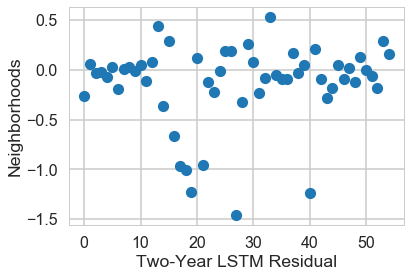

In [84]:
plt.plot(residslstm, 'o')
plt.ylabel('Neighborhoods')
plt.xlabel('Two-Year LSTM Residual')
plt.show()

# Model 5: STARIMA
So far, we have attempted to predict each neighborhood individually, adding features to account for potential self-dependence in space and time. However, there are models called _autoregressive models_ that use this self-dependence for prediction. The [Spatio-Temporal Autoregressive Moving Average](http://www.jstor.org.ezp-prod1.hul.harvard.edu/stable/621846?sid=primo&origin=crossref&seq=1#page_scan_tab_contents) (STARIMA) model is one such model that does this. The STARIMA model expresses $y_i(t)$, the rent in neighborhood $i$ at time $t$, as a function of both spatially and temporally lagged rent and errors. For $Y \in \mathbb{R}^n$, we say that
$$ \nabla^d Y(t) = \sum_{k = 1}^p \sum_{l = 0}^{\lambda_k} \phi_{kl} \mathbf{W}^{(l)}\nabla^dY(t - k)  + \epsilon(t) - \sum_{k=1}^q \sum_{l=0}^{m_k}\theta_{kl} \mathbf{W}^{(l)}\epsilon(t-k)$$

Where 
* $\nabla$ is the difference operator such that
$$\nabla Y(t) = Y(t) - Y(t-1)$$
$$\nabla^2 Y(t) = \nabla [\nabla Y(t)] = Y(t) - 2Y(t-1) + Y(t-2)$$
$$\vdots$$
$$\nabla^m Y(t) = \nabla[\nabla^{m-1}Y(t)]$$
* $p$ is the autoregressive order
* $d$ is the number of differences
* $q$ is the moving average order
* $\lambda_k$ is the spatial order of the $k$th autoregressive term
* $m_k$ is the spatial order of the $k$th moving average term
* $\phi_{kl}$ is the autoregressive parameter at temporal lag $k$ and spatial lag $l$
* $\theta$ is the moving average parameter at temporal lag $k$ and spatial lag $l$
* $W^{(l)}$ is the $N\times N$ matrix of weights for spatial order $l$
* $\epsilon \sim N(0, \sigma^2 I)$ is temporally uncorrelated Gaussian noise, so that $E[\epsilon(t)\epsilon(s)^T] = 0$ for $s \neq t$

Assuming $E[y(t)]=0$, we define the time autocovariance function
$$\Gamma(s) = E\left[(y(t) - E[y(t)])(y(t+s)-E[y(t+s)])^T\right]$$
Which gives us the covariance of a signal with itself $s$ time-steps in the future. This allows us to define parameter
$$\gamma_{kl}(s) = E\left\{\frac{(W^{l}y(t))^T(W^{(k)}y(t+s))}{N}\right\} \equiv tr\left\{\frac{(W^{(k)}y(t))^T(W^{(l)}y(t+s))}{N}\right\}$$
For $N$ neighborhoods. The average autocovariance between weighted $k$th and $l$th-order neighbors $s$ time steps in the future. To get the space-time autocorrelation $\rho_{lk}(s)$, we generalize the formula $Corr(\mathbf{X}) = (\text{diag}(\Sigma))^{-1/2})\Sigma(\text{diag}(\Sigma))^{-1/2})$ to arrive at
$$\rho_{lk}(s) = \frac{\gamma_{kl}(s)}{[\gamma_{ll}(0)\gamma_{kk}(0)]^{1/2}}$$
We estimate $\gamma_{lk}$ by the mean:
$$ \hat{\gamma}_{lk}(s) = \sum_{t=1}^{T-s}\frac{ [ W^{(l)} y(t)]^T[ W^{(k)} y(t+s)]}{N(T-s)}$$
Therefore
$$ \hat{\rho}_{lk}(s) = \frac{\hat{\gamma}_{lk}}{{(\hat{\gamma}_{ll}(0)\hat{\gamma}_{kk}(0))^{1/2}}}$$

In [85]:
W0 = np.identity(k)

In [86]:
# First-degree neighbor matrix
W1 = W

In [87]:
# Second-degree neighbors
W2 = np.matlib.zeros((k,k))
for v in G.nodes():
    s = set()
    neighbors1 = G[v].keys()
    for j in neighbors1:
        neighbors2 = G[j].keys()
        s = s.union(set(neighbors2))
    s = s.difference(set(neighbors1))
    W2[v,list(s)] = 1
for i, row in enumerate(W2):
    W2[i] = row / row.sum()

In [88]:
# Third-degree neighbors
W3 = np.matlib.zeros((k,k))
for i in range(k):
    s = set()
    neighbors1 = np.nonzero(W1[i,:])[1].tolist()
    neighbors2 = np.nonzero(W2[i,:])[1].tolist()
    neighborslower = set(neighbors1).union(set(neighbors2))
    for j in neighbors2:
        neighbors3 = G[j].keys()
        s = s.union(set(neighbors3))
    s = s.difference(neighborslower)
    W3[i,list(s)] = 1
for i,row in enumerate(W3):
    W3[i] = row/ row.sum()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in divide
  


In [89]:
def autocovariance(l,m,s,v,M):
    if l == 0:
        Wl = W0
    elif l == 1:
        Wl = W1
    elif l == 2:
        Wl = W2
    else:
        Wl = W3
    
    if m == 0:
        Wk = W0
    elif m == 1:
        Wk = W1
    elif m == 2:
        Wk = W2
    else:
        Wk = W3
        
    g = 0.0
    for i in range(v - s):
        g = g + np.sum((Wl * M[:,i].reshape((k,1))).T * (Wk * M[:,i + s].reshape((k,1))))/(k * (n-s))
    return g

In [90]:
def autocorrelation(l,m,s,v,M):
    return autocovariance(l,m,s,v,M) / np.sqrt((autocovariance(l,l,0,v,M)*autocovariance(m,m,0,v,M)))

ARMA models assume that a distribution is a _stationary process_, meaning that the unconditional joint PDF does not change over time. To ensure this, we take $w(t) = \nabla y(t) = y(t) - y(t-1)$ and look at the autocorrelation for this first-order difference

In [91]:
W = Y[:,:-1] - Y[:,1:]

We calculate the matrix
$$\begin{bmatrix}\rho_{00}(1) & \hat{\rho}_{10}(1) & \hat{\rho}_{30}(1) \\ \hat{\rho}_{00}(2) & \hat{\rho}_{10}(2) & \hat{\rho}_{30}(2)\\ \hat{\rho}_{00}(3) & \hat{\rho}_{10}(3) & \hat{\rho}_{30}(3)\end{bmatrix}$$

In [99]:
M = np.matlib.zeros((3,3))
for i in range(3):
    for j in range(3):
        print i,j
        M[i,j] = autocorrelation(i,0,j,9,W)
M

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


matrix([[ 1.        , -0.37668867,  0.19801372],
        [ 0.19590022,  0.16257736,  0.01480249],
        [ 0.55548733, -0.07627127,  0.20129899]])

The result is only weakly autocorrelated for any reasonable lag, and thus we didn't move forward with this model.

# Prediction Step
First, we look at the low-income neighborhoods as we defined in the introduction

In [100]:
income_diffs = pd.DataFrame(index = median_incomes.index, columns=['Sub-Borough Area'])
income_diffs['Sub-Borough Area'] = median_incomes['Sub-Borough Area']
income_diffs['2005'] = median_incomes['2005'] - nyc_median_incomes['2005'][0]
low_income = income_diffs['2005'] < income_diffs['2005'].quantile(q=0.4)
income_diffs[low_income]['Sub-Borough Area']

puma
3705                      Morrisania/Belmont
3706             Kingsbridge Heights/Moshulu
3707              University Heights/Fordham
3708              Highbridge/South Concourse
3709                   Soundview/Parkchester
3710                  Mott Haven/Hunts Point
3801               Washington Heights/Inwood
3802    Morningside Heights/Hamilton Heights
3803                          Central Harlem
3804                             East Harlem
3809               Lower East Side/Chinatown
4001                 Williamsburg/Greenpoint
4002                                Bushwick
4003                      Bedford Stuyvesant
4006    North Crown Heights/Prospect Heights
4007                  Brownsville/Ocean Hill
4008             East New York/Starrett City
4011                     South Crown Heights
4014                            Borough Park
4015                                Flatbush
4018                            Coney Island
4101                                 Astoria
Name:

We look at the average rate increase of median rent for each neighborhood over the period of study, as well as for New York as a whole during the period of study. We use our best predictions, which come from the random forest regressor:

In [261]:
predicted_2016_rent = np.zeros(k)
for i in range(k):
    regr = RandomForestRegressor()
    regr.fit(X_train[i], Y_train[i])
    predicted_2016_rent[i] = regr.predict(X_test[i,1].reshape(1, -1))

In [262]:
# Put first observation in normalized space
rents_2005 = median_rents['2005'].astype('float32').values.reshape(k,1)
newY = median_rents[obs_years].astype('float32').values
m = np.mean(newY, axis = 1).reshape(k,1)
newY = newY - np.repeat(m, n, axis = 1)
rents_2005 = rents_2005 - m
Y_norm = np.linalg.norm(newY, axis = 1).reshape(k,1)
rents_2005 = np.divide(rents_2005, Y_norm)

predicted_rent_increases = predicted_2016_rent.reshape(k,1) - rents_2005
rent_increases = Y[:,-1].reshape(k,1) - rents_2005

In [252]:
sum_years = [str(y) for y in range(2006,2017)]
nyc_median_rents = nyc_median_rents[years] - nyc_median_rents[sum_years].values.mean()
nyc_median_rents = nyc_median_rents / np.sum(np.square(nyc_median_rents[sum_years].values))
nyc_rent_increase = nyc_median_rents['2016'] - nyc_median_rents['2005']

We subtract the increase of median rents of NYC as a whole over the same period

In [253]:
nyc_rent_increase

0    0.004309
dtype: float64

For our predictions this yields

In [263]:
predicted_minus_nyc = predicted_rent_increases - nyc_rent_increase.values
predicted_minus_nyc

array([[ 0.60351813],
       [ 0.89227019],
       [ 0.76530622],
       [ 0.41681533],
       [ 0.64569086],
       [ 0.65285328],
       [ 0.82405438],
       [ 0.81897921],
       [ 0.2790708 ],
       [ 0.87704926],
       [ 0.46287417],
       [ 0.74406289],
       [ 0.49158543],
       [ 0.40853638],
       [ 0.05755516],
       [ 0.76789461],
       [-0.39739902],
       [-0.2606783 ],
       [ 0.53142101],
       [-0.35423794],
       [ 0.15743321],
       [-0.30210695],
       [-0.13219589],
       [ 0.33094811],
       [ 0.70445039],
       [ 0.3840097 ],
       [ 0.6238759 ],
       [-0.46493666],
       [ 0.26163669],
       [ 0.57759844],
       [ 1.45160726],
       [ 0.19485303],
       [ 0.46473247],
       [ 0.50556837],
       [ 0.51464705],
       [ 0.75866317],
       [ 0.60009999],
       [ 0.35216552],
       [ 0.1643913 ],
       [ 0.1431393 ],
       [ 0.06773378],
       [ 0.66636836],
       [ 0.27206628],
       [ 0.19940992],
       [ 0.53954932],
       [ 0

For the actual data, it is

In [264]:
actual_minus_nyc = rent_increases - nyc_rent_increase.values
actual_minus_nyc

array([[ 1.07409412],
       [ 1.07880682],
       [ 1.15011388],
       [ 0.82057381],
       [ 1.32902414],
       [ 0.77233738],
       [ 1.14996797],
       [ 1.07738358],
       [ 0.88125318],
       [ 1.47231227],
       [ 0.94312555],
       [ 0.97457415],
       [ 0.73583198],
       [ 0.36490232],
       [ 0.50185305],
       [ 1.38484055],
       [ 0.43245742],
       [ 0.47954258],
       [ 0.83390808],
       [ 0.28683165],
       [-0.32779378],
       [ 0.30682293],
       [ 0.46685267],
       [ 0.92053837],
       [ 1.16397578],
       [ 1.09422439],
       [ 1.00022096],
       [ 0.40332589],
       [ 0.97715753],
       [ 0.79832202],
       [ 1.74980694],
       [ 0.71991688],
       [ 1.11731202],
       [ 0.82740593],
       [ 1.04134888],
       [ 1.20265275],
       [ 0.88744205],
       [ 0.73322457],
       [ 0.5699901 ],
       [ 0.77173519],
       [ 0.71611977],
       [ 0.86198264],
       [ 0.85936397],
       [ 1.08704275],
       [ 0.62039316],
       [ 0

For all our low-income neighborhoods, the rent increase is predicted to be greater

In [259]:
predicted_minus_nyc[low_income.values]

array([[ 0.67902419],
       [ 0.55726602],
       [ 0.68825708],
       [ 0.77090398],
       [ 0.34991578],
       [ 0.81244708],
       [ 0.46287417],
       [ 0.87037041],
       [ 0.42127202],
       [ 0.32462469],
       [ 0.47311024],
       [ 0.62253198],
       [ 0.54089051],
       [ 0.47087049],
       [ 0.26163669],
       [ 0.58963791],
       [ 1.66210119],
       [ 0.31391229],
       [ 0.50762209],
       [ 0.31119142],
       [ 0.15006851],
       [ 0.60768408]])

This is borne out in the actual data

In [260]:
actual_minus_nyc[low_income.values]

array([[ 1.32902414],
       [ 0.77233738],
       [ 1.14996797],
       [ 1.07738358],
       [ 0.88125318],
       [ 1.47231227],
       [ 0.94312555],
       [ 0.97457415],
       [ 0.73583198],
       [ 0.36490232],
       [ 0.83390808],
       [ 0.92053837],
       [ 1.16397578],
       [ 1.09422439],
       [ 0.97715753],
       [ 0.79832202],
       [ 1.74980694],
       [ 0.82740593],
       [ 0.88744205],
       [ 0.73322457],
       [ 0.71611977],
       [ 0.86198264]])